# Pareamento Estatístico com Grupos Pareados

Este notebook demonstra como aplicar o pareamento estatístico usando escore de propensão em um conjunto de dados simulado de saúde.

**Objetivo:** Comparar se um tratamento tem efeito sobre a melhora dos pacientes, ajustando para variáveis de confusão.

## Passos:
1. Gerar dados simulados
2. Calcular escore de propensão
3. Realizar pareamento 1:1
4. Avaliar balanceamento
5. Comparar desfecho

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Simulando um dataset fictício de saúde
np.random.seed(42)
n = 200
idade = np.random.normal(50, 10, n).astype(int)
sexo = np.random.choice(['M', 'F'], size=n)
fumante = np.random.choice([0, 1], size=n)
pressao = np.random.normal(120, 15, n)
tratamento = np.random.choice([0, 1], size=n, p=[0.6, 0.4])
resultado = (0.3 * tratamento + 0.02 * idade - 0.1 * fumante + np.random.normal(0, 1, n)) > 0.5
resultado = resultado.astype(int)

df = pd.DataFrame({
    'Idade': idade,
    'Sexo': sexo,
    'Fumante': fumante,
    'Pressao': pressao,
    'Tratamento': tratamento,
    'Melhorou': resultado
})

df['Sexo_bin'] = (df['Sexo'] == 'M').astype(int)
df.head()

## Cálculo do Escore de Propensão
Usamos regressão logística para estimar a probabilidade de um paciente receber o tratamento com base em variáveis observadas.

In [2]:
X = df[['Idade', 'Sexo_bin', 'Fumante', 'Pressao']]
y = df['Tratamento']
model = LogisticRegression()
model.fit(X, y)
df['propensity_score'] = model.predict_proba(X)[:, 1]
df[['propensity_score']].describe()

,propensity_score
count,200.000000
mean,0.365000
std,0.072084
min,0.208231
25%,0.307943
50%,0.362208
75%,0.411511
max,0.533731


## Pareamento 1:1 por Vizinhos Mais Próximos
Selecionamos para cada paciente tratado, um controle com score mais próximo.

In [3]:
tratados = df[df['Tratamento'] == 1]
controles = df[df['Tratamento'] == 0]
nn = NearestNeighbors(n_neighbors=1)
nn.fit(controles[['propensity_score']])
dists, indices = nn.kneighbors(tratados[['propensity_score']])
pareados = controles.iloc[indices.flatten()]
df_pareado = pd.concat([tratados.reset_index(drop=True), pareados.reset_index(drop=True)])
df_pareado['Grupo'] = ['Tratado'] * len(tratados) + ['Controle'] * len(pareados)
df_pareado.head()

,Idade,Sexo,Fumante,Pressao,Tratamento,Melhorou,Sexo_bin,propensity_score,Grupo
0,48,F,1,126.025676,1,0,0,0.398330,Tratado
1,65,F,0,113.981693,1,1,0,0.240076,Tratado
2,45,F,1,120.367653,1,1,0,0.407307,Tratado
3,45,F,1,134.389062,1,1,0,0.410749,Tratado
4,32,M,1,133.084810,1,0,1,0.533731,Tratado


## Comparando Propensity Scores nos Grupos Pareados

/var/folders/yq/pq2twqh913s0mr445r3_jz7h0000gn/T/ipykernel_8589/2312792735.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df_pareado[df_pareado['Grupo'] == 'Tratado']['propensity_score'],


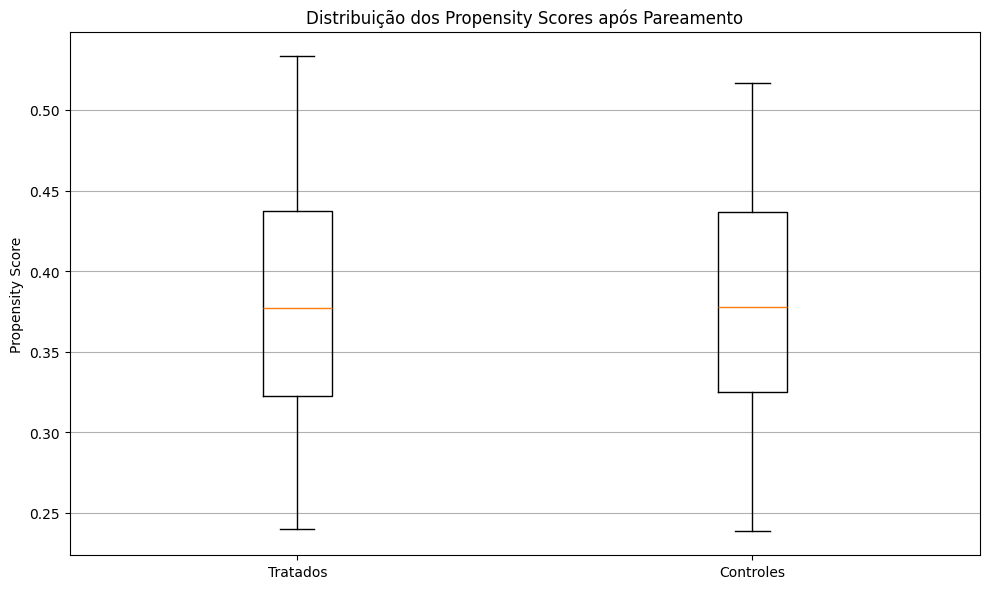

In [4]:
plt.figure(figsize=(10, 6))
plt.boxplot([df_pareado[df_pareado['Grupo'] == 'Tratado']['propensity_score'],
             df_pareado[df_pareado['Grupo'] == 'Controle']['propensity_score']],
            labels=['Tratados', 'Controles'])
plt.title('Distribuição dos Propensity Scores após Pareamento')
plt.ylabel('Propensity Score')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## Comparando o Desfecho `Melhorou`
Vamos ver se houve diferença na taxa de melhora entre os grupos pareados.

In [5]:
df_pareado.groupby('Grupo')['Melhorou'].mean()

Grupo
Controle    0.684932
Tratado     0.780822
Name: Melhorou, dtype: float64

## Correlações

### Correlação Positiva

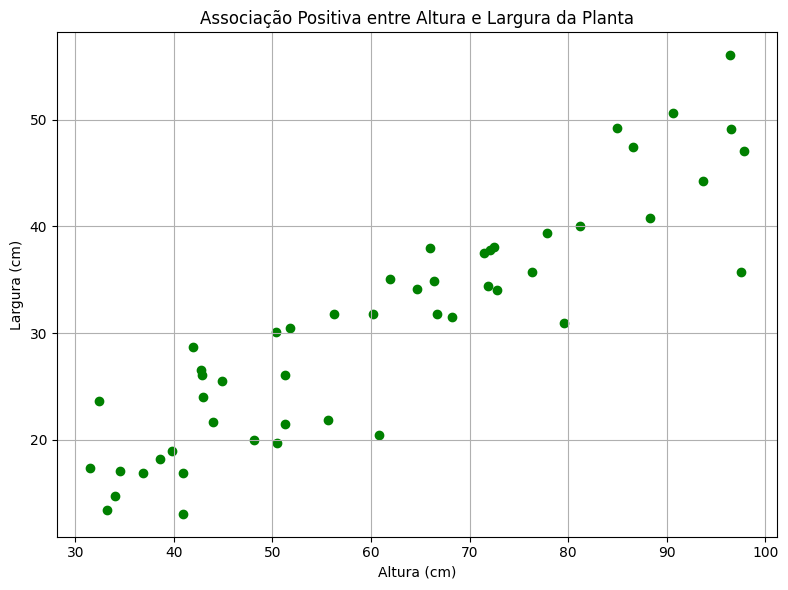

,Altura_cm,Largura_cm
0,56.217808,31.801237
1,96.550001,49.131842
2,81.239576,40.041547
3,71.906094,34.447528
4,40.921305,13.068042


In [6]:
# Dataset fictício com correlação positiva entre altura e largura da planta
np.random.seed(42)
n = 50

# Altura em cm (variando entre 30 e 100)
altura = np.random.uniform(30, 100, n)

# Largura em cm com correlação positiva com a altura + algum ruído
largura = 0.5 * altura + np.random.normal(0, 5, n)

# Criar DataFrame
df_plantas = pd.DataFrame({
    'Altura_cm': altura,
    'Largura_cm': largura
})

# Plotar a correlação
plt.figure(figsize=(8, 6))
plt.scatter(df_plantas['Altura_cm'], df_plantas['Largura_cm'], color='green')
plt.title('Associação Positiva entre Altura e Largura da Planta')
plt.xlabel('Altura (cm)')
plt.ylabel('Largura (cm)')
plt.grid(True)
plt.tight_layout()
plt.show()

df_plantas.head()


### Correlação Negativa

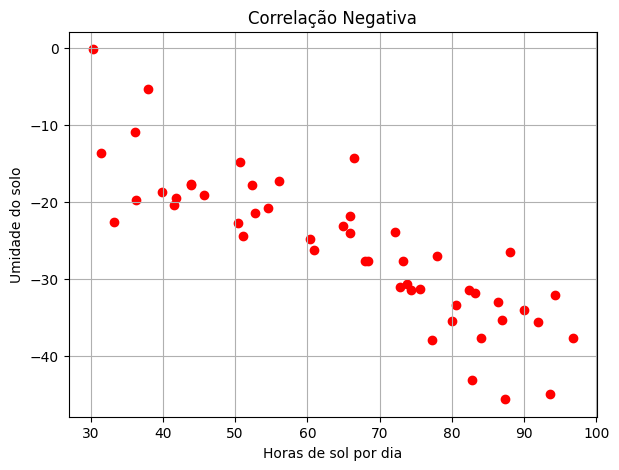

In [7]:
# Criar dataset com correlação negativa entre duas variáveis
np.random.seed(10)
x_neg = np.random.uniform(30, 100, n)
y_neg = -0.4 * x_neg + np.random.normal(0, 5, n)

# Gráfico de correlação negativa
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.scatter(x_neg, y_neg, color='red')
plt.title('Correlação Negativa')
plt.xlabel('Horas de sol por dia')
plt.ylabel('Umidade do solo')
plt.grid(True)
plt.show()

### Sem Correlação

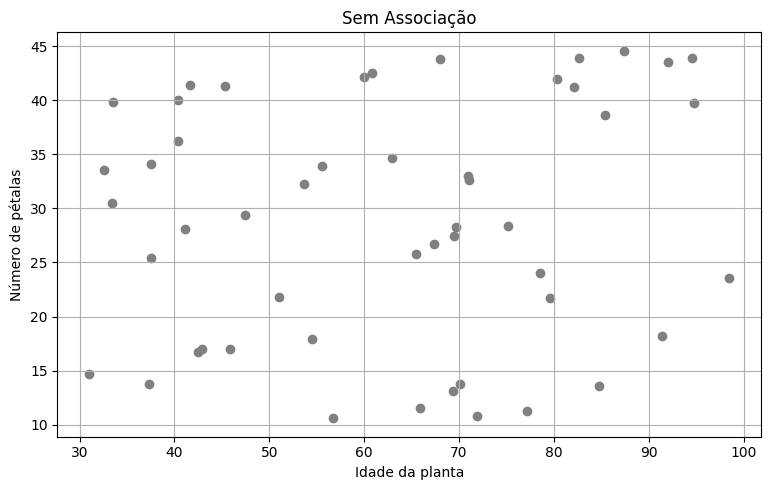

In [8]:
# Dataset sem associação
x_none = np.random.uniform(30, 100, n)
y_none = np.random.uniform(10, 50, n)  # totalmente aleatório

# Gráfico sem correlação 
plt.figure(figsize=(15, 5))
# Gráfico sem correlação
plt.subplot(1, 2, 2)
plt.scatter(x_none, y_none, color='gray')
plt.title('Sem Associação')
plt.xlabel('Idade da planta')
plt.ylabel('Número de pétalas')
plt.grid(True)

plt.tight_layout()
plt.show()

## Variáveis Dependentes e Independentes

<Figure size 800x600 with 0 Axes>

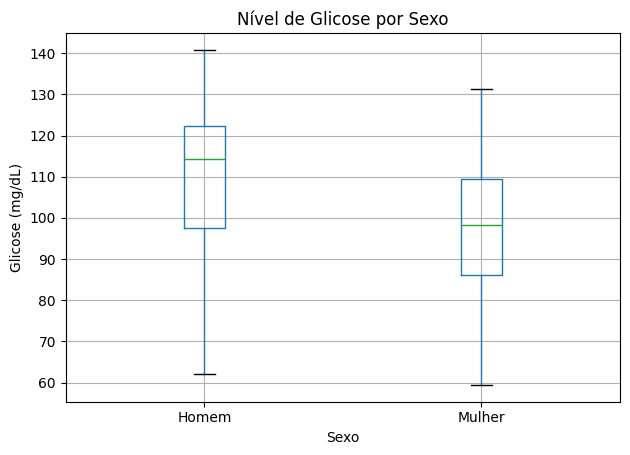

,Sexo,Glicose
0,Homem,123.258397
1,Homem,112.937975
2,Homem,115.363048
3,Homem,74.851071
4,Homem,93.727511


In [9]:
# Gerar dados fictícios de sexo e nível de glicose
np.random.seed(20)
n_homens = 50
n_mulheres = 50

# Glicose em mg/dL (valores simulados com média um pouco maior nos homens)
glicose_homens = np.random.normal(110, 15, n_homens)
glicose_mulheres = np.random.normal(100, 15, n_mulheres)

# Criar DataFrame
sexo = ['Homem'] * n_homens + ['Mulher'] * n_mulheres
glicose = np.concatenate([glicose_homens, glicose_mulheres])
df_glicose = pd.DataFrame({
    'Sexo': sexo,
    'Glicose': glicose
})

# Plotar boxplot
plt.figure(figsize=(8, 6))
df_glicose.boxplot(column='Glicose', by='Sexo', grid=True)
plt.title('Nível de Glicose por Sexo')
plt.suptitle('')
plt.ylabel('Glicose (mg/dL)')
plt.xlabel('Sexo')
plt.tight_layout()
plt.show()

df_glicose.head()


## Qui-quadrado

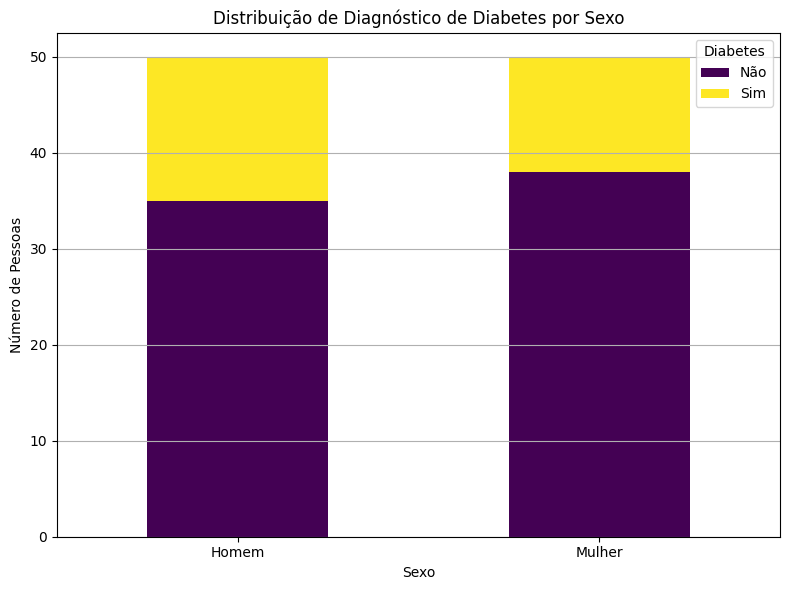

(Diabetes  Não  Sim
 Sexo              
 Homem      35   15
 Mulher     38   12,
 np.float64(0.20294266869609334),
 np.float64(0.6523560200667963))

In [10]:
from scipy.stats import chi2_contingency

# Exemplo de variáveis qualitativas nominais: Sexo (Homem/Mulher) x Diagnóstico de Diabetes (Sim/Não)
sexo = ['Homem'] * 50 + ['Mulher'] * 50
diabetes = np.random.choice(['Sim', 'Não'], size=100, p=[0.4, 0.6])  # distribuição fictícia

df_nominal = pd.DataFrame({
    'Sexo': sexo,
    'Diabetes': diabetes
})

# Tabela de contingência
contingencia = pd.crosstab(df_nominal['Sexo'], df_nominal['Diabetes'])

# Teste Qui-Quadrado
chi2, p, dof, expected = chi2_contingency(contingencia)

# Plotar gráfico de barras empilhadas
contingencia.plot(kind='bar', stacked=True, figsize=(8, 6), colormap='viridis')
plt.title('Distribuição de Diagnóstico de Diabetes por Sexo')
plt.xlabel('Sexo')
plt.ylabel('Número de Pessoas')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

contingencia, chi2, p
